# Fully-Connected Neural Nets
In this exercise we will implement fully-connected networks on MNIST datasets. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Batch Normalization as a tool to more efficiently optimize deep networks.
  

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from stats202a.classifiers.fc_net import *
from stats202a.data_utils import get_mnist_data
from stats202a.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from stats202a.solver import Solver
from stats202a.layers import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%reload_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

## Download data 

you need to download the MNIST datasets.
Run the following bash in the `stats202a/datasets` directory: `./get_datasets.sh` (for windows, run `./get_datasets.cmd`)

In [2]:
# Load the (preprocessed) MNIST data.
# The second dimension of images indicated the number of channel. For black and white images in MNIST, channel=1.
data = get_mnist_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (59000, 1, 28, 28))
('y_train: ', (59000,))
('X_val: ', (1000, 1, 28, 28))
('y_val: ', (1000,))
('X_test: ', (10000, 1, 28, 28))
('y_test: ', (10000,))


# Fully-connected layer: foward
Open the file `stats202a/layers.py` and implement the `fc_forward` function.

Once you are done you can test your implementaion by running the following:

In [3]:
# Test the fc_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = fc_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing fc_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing fc_forward function:
difference:  9.769847728806635e-10


In [4]:
# Test the fc_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: fc_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: fc_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: fc_forward(x, w, b)[0], b, dout)

_, cache = fc_forward(x, w, b)
dx, dw, db = fc_backward(dout, cache)

# The error should be around 1e-10
print('Testing fc_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing fc_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


# Fully-connected layer: backward
Now implement the `fc_backward` function and test your implementation using numeric gradient checking.

# ReLU layer: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [5]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 5e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU layer: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [6]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)
dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)
_, cache = relu_forward(x)
dx = relu_backward(dout, cache)
# The error should be around 3e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, fc/conv layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `stats202a/layer_utils.py`.

Implement the `fc_relu_forward` and `fc_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [7]:
from stats202a.layer_utils import fc_relu_forward, fc_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = fc_relu_forward(x, w, b)
dx, dw, db = fc_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: fc_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: fc_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: fc_relu_forward(x, w, b)[0], b, dout)

print('Testing affine_relu_forward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward:
dx error:  6.750562121603446e-11
dw error:  8.162015570444288e-11
db error:  7.826724021458994e-12


# Loss layers: Softmax
Now implement the softmax loss in the `softmax_loss` function. 

The softmax loss is in the following form:
$$L_i = -\log(exp(x_{iy_i})/\sum_j(exp(x_{ij}))) $$
$x_i$ is the output of the top fc layer for input image $i$, $y_i$ is the true label of $x_i$, and $j$ is the index of category.
To avoid overflow, you may follow the trick in https://www.xarg.org/2016/06/the-log-sum-exp-trick-in-machine-learning/ to compute the 'logsumexp' operation.


You can make sure that the implementations are correct by running the following:

In [8]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))


Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.384673161989355e-09


# Two-layer network
First we implement a two-layer network with only one hidden layer. We will use the class TwoLayerNet in the file `stats202a/classifiers/fc_net.py` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are numpy arrays.

Besides softmax loss, we add another L2 regularization loss: $||W||_2^2$, where $W$ is the weights of all layers. Bias are not included. We use a parameter `self.reg` to control the strength of regularization.

Open the file `stats202a/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [9]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C)

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'


model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
    print('Running numeric gradient check with reg = ', reg)
    model.reg = 0
    loss, grads = model.loss(X, y)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.22e-08
W2 relative error: 3.48e-10
b1 relative error: 6.55e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 1.22e-08
W2 relative error: 3.48e-10
b1 relative error: 6.55e-09
b2 relative error: 4.33e-10


# Solver
We use a separate class to define the training process.

Open the file `stats202a/solver.py` and read through it to familiarize yourself with the API. You can use a `Solver` instance to train a `TwoLayerNet` that achieves at least `97%` accuracy on the validation set. Just run the code. 

In [10]:
model = TwoLayerNet()
solver = None

solver = Solver(model, data,
              update_rule='sgd',
              optim_config={
                'learning_rate': 1e-3,
              },
              lr_decay=0.95,
              num_epochs=10, batch_size=200,
              print_every=100)
solver.train()


(Iteration 1 / 2950) loss: 2.302585
(Epoch 0 / 10) train acc: 0.107000; val_acc: 0.093000
(Iteration 101 / 2950) loss: 1.448799
(Iteration 201 / 2950) loss: 0.465498
(Epoch 1 / 10) train acc: 0.910000; val_acc: 0.842000
(Iteration 301 / 2950) loss: 0.395597
(Iteration 401 / 2950) loss: 0.265204
(Iteration 501 / 2950) loss: 0.279966
(Epoch 2 / 10) train acc: 0.920000; val_acc: 0.860000
(Iteration 601 / 2950) loss: 0.245076
(Iteration 701 / 2950) loss: 0.155889
(Iteration 801 / 2950) loss: 0.296768
(Epoch 3 / 10) train acc: 0.939000; val_acc: 0.866000
(Iteration 901 / 2950) loss: 0.215426
(Iteration 1001 / 2950) loss: 0.164655
(Iteration 1101 / 2950) loss: 0.143659
(Epoch 4 / 10) train acc: 0.943000; val_acc: 0.868000
(Iteration 1201 / 2950) loss: 0.243315
(Iteration 1301 / 2950) loss: 0.159187
(Iteration 1401 / 2950) loss: 0.107042
(Epoch 5 / 10) train acc: 0.948000; val_acc: 0.866000
(Iteration 1501 / 2950) loss: 0.125140
(Iteration 1601 / 2950) loss: 0.168138
(Iteration 1701 / 2950) l

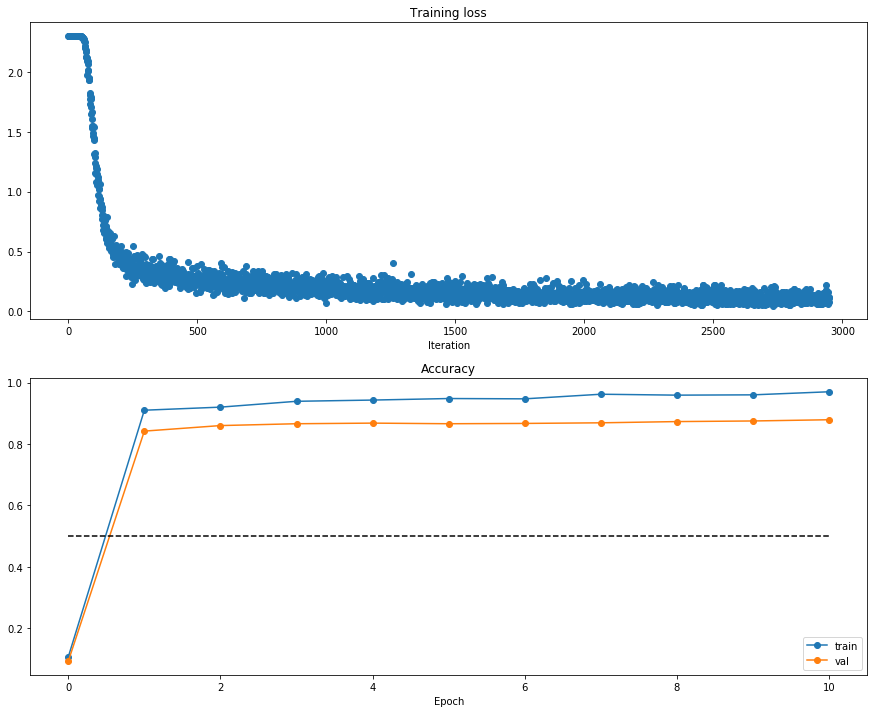

In [11]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network (Optional)
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `stats202a/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch normalization; we will add those features soon.

As a sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. You will need to tweak the learning rate and initialization scale, but you should be able to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 2.287239
(Epoch 0 / 20) train acc: 0.000000; val_acc: 0.183000
(Epoch 1 / 20) train acc: 0.000000; val_acc: 0.181000
(Epoch 2 / 20) train acc: 0.000000; val_acc: 0.366000
(Epoch 3 / 20) train acc: 0.000000; val_acc: 0.427000
(Epoch 4 / 20) train acc: 0.000000; val_acc: 0.517000
(Epoch 5 / 20) train acc: 0.000000; val_acc: 0.548000
(Iteration 11 / 40) loss: 0.409455
(Epoch 6 / 20) train acc: 0.000000; val_acc: 0.530000
(Epoch 7 / 20) train acc: 0.000000; val_acc: 0.405000
(Epoch 8 / 20) train acc: 0.000000; val_acc: 0.546000
(Epoch 9 / 20) train acc: 0.000000; val_acc: 0.575000
(Epoch 10 / 20) train acc: 0.000000; val_acc: 0.570000
(Iteration 21 / 40) loss: 0.254674
(Epoch 11 / 20) train acc: 0.000000; val_acc: 0.598000
(Epoch 12 / 20) train acc: 0.000000; val_acc: 0.604000
(Epoch 13 / 20) train acc: 0.000000; val_acc: 0.605000
(Epoch 14 / 20) train acc: 0.000000; val_acc: 0.601000
(Epoch 15 / 20) train acc: 0.000000; val_acc: 0.603000
(Iteration 31 / 40) loss: 

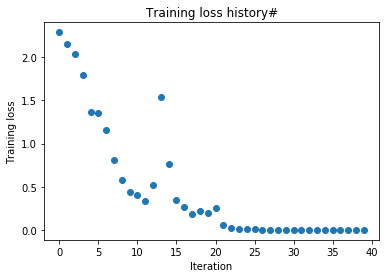

In [12]:
# TODO: Use a three-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

small_data['X_train'].shape

weight_scale = 1e-2
learning_rate = 3e-2
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history#')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 4000) loss: 3.867697
(Epoch 0 / 20) train acc: 0.151000; val_acc: 0.149000
(Iteration 11 / 4000) loss: 1.772184
(Iteration 21 / 4000) loss: 0.974959
(Iteration 31 / 4000) loss: 1.099302
(Iteration 41 / 4000) loss: 1.558395
(Iteration 51 / 4000) loss: 0.908804
(Iteration 61 / 4000) loss: 0.671296
(Iteration 71 / 4000) loss: 0.537319
(Iteration 81 / 4000) loss: 0.699184
(Iteration 91 / 4000) loss: 0.354858
(Iteration 101 / 4000) loss: 0.385568
(Iteration 111 / 4000) loss: 0.171716
(Iteration 121 / 4000) loss: 1.171966
(Iteration 131 / 4000) loss: 0.306981
(Iteration 141 / 4000) loss: 0.195146
(Iteration 151 / 4000) loss: 0.497688
(Iteration 161 / 4000) loss: 0.134217
(Iteration 171 / 4000) loss: 0.820594
(Iteration 181 / 4000) loss: 0.318319
(Iteration 191 / 4000) loss: 0.103606
(Epoch 1 / 20) train acc: 0.904000; val_acc: 0.801000
(Iteration 201 / 4000) loss: 0.269296
(Iteration 211 / 4000) loss: 0.144963
(Iteration 221 / 4000) loss: 0.426512
(Iteration 231 / 4000) loss: 

(Iteration 2021 / 4000) loss: 0.170228
(Iteration 2031 / 4000) loss: 0.017729
(Iteration 2041 / 4000) loss: 0.014983
(Iteration 2051 / 4000) loss: 0.188098
(Iteration 2061 / 4000) loss: 0.114279
(Iteration 2071 / 4000) loss: 0.038347
(Iteration 2081 / 4000) loss: 0.314616
(Iteration 2091 / 4000) loss: 0.000443
(Iteration 2101 / 4000) loss: 0.003866
(Iteration 2111 / 4000) loss: 0.005527
(Iteration 2121 / 4000) loss: 0.249919
(Iteration 2131 / 4000) loss: 0.039533
(Iteration 2141 / 4000) loss: 0.034370
(Iteration 2151 / 4000) loss: 0.001778
(Iteration 2161 / 4000) loss: 0.071036
(Iteration 2171 / 4000) loss: 0.385448
(Iteration 2181 / 4000) loss: 0.305875
(Iteration 2191 / 4000) loss: 0.103726
(Epoch 11 / 20) train acc: 0.973000; val_acc: 0.832000
(Iteration 2201 / 4000) loss: 0.242741
(Iteration 2211 / 4000) loss: 0.050192
(Iteration 2221 / 4000) loss: 1.021473
(Iteration 2231 / 4000) loss: 1.659197
(Iteration 2241 / 4000) loss: 0.086408
(Iteration 2251 / 4000) loss: 0.000732
(Iteratio

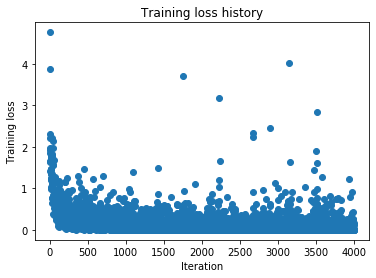

In [14]:
# TODO: Use a five-layer Net to overfit 50 training examples.

num_train = 5000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 5e-2
weight_scale = 5e-2
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()